# 🚗 Automatic Number Plate Recognition (ANPR)
This project demonstrates how to detect and recognize license plates using **OpenCV** for image processing and **Tesseract OCR** for text recognition.


In [1]:
# 📦 Import required libraries
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

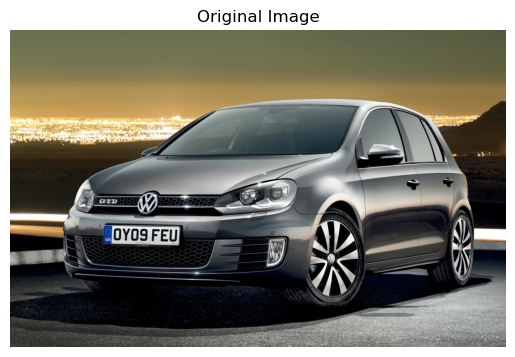

In [2]:
# 🖼️ Load the input image
image_path = 'car-4.jpg'
image = cv2.imread(image_path)
if image is not None: 
    'Image not found! Please check the path.'
orig_image = image.copy()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

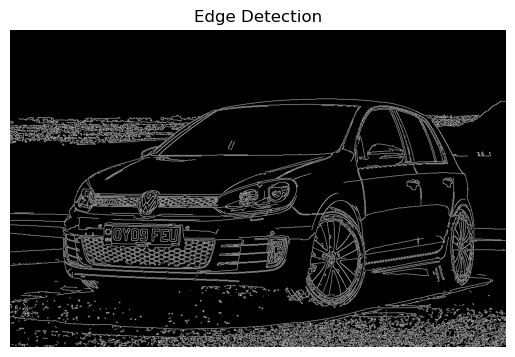

In [3]:
# 🧼 Preprocess the image
gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(gray, 200, 100)

plt.imshow(edged, cmap='gray')
plt.title('Edge Detection')
plt.axis('off')
plt.show()

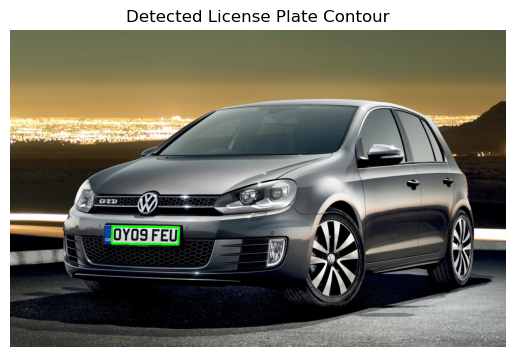

In [4]:
# 🔍 Detect contours to find possible license plates

#Find the Edges
contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
#Sorting the edges ,reverseing it and taking only first 10(Considering number is one of them)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] 

plate_contour = None
# From Contour finding which has 4-edges
for c in contours:
    approx = cv2.approxPolyDP(c, 0.02 * cv2.arcLength(c, True), True) 
    if len(approx) == 4:
        plate_contour = approx
        break

# Drawing line on the ROI
if plate_contour is not None:
    cv2.drawContours(image, [plate_contour], -1, (0, 255, 0), 3)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Detected License Plate Contour')
    plt.axis('off')
    plt.show()
else:
    print('License plate contour not found.')

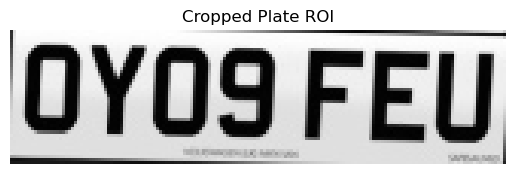

In [5]:
# ✂️ Extract Region of Interest (ROI)
cropped = None
if plate_contour is not None:
    mask = np.zeros(gray.shape, dtype=np.uint8)
    cv2.drawContours(mask, [plate_contour], -1, 255, -1)
    result = cv2.bitwise_and(orig_image, orig_image, mask=mask)
    (x, y) = np.where(mask == 255)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))
    cropped = gray[topx:bottomx+1, topy:bottomy+1]
    plt.imshow(cropped, cmap='gray')
    plt.title('Cropped Plate ROI')
    plt.axis('off')
    plt.show()

In [6]:
# 🔡 Extracting the text from Image using Tesseract OCR
text = pytesseract.image_to_string(cropped, config='--psm 8 --psm 12')
print(f'Recognized Text: {text.strip()}')

Recognized Text: OYO9 FEU


In [7]:
# 🎥 Real-time License Plate Recognition (Press 'q' to quit)
def real_time_anpr():
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edged = cv2.Canny(blurred, 400, 100)
        contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            approx = cv2.approxPolyDP(c, 0.018 * cv2.arcLength(c, True), True)
            if len(approx) == 4:
                x, y, w, h = cv2.boundingRect(approx)
                roi = gray[y:y+h, x:x+w]
                text = pytesseract.image_to_string(roi, config='--psm 8')
                if len(text.strip()) > 4:
                    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    cv2.putText(frame, text.strip(), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        cv2.imshow('Real-Time ANPR', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# Uncomment below to run in real time
real_time_anpr()